# Project Title: Film Junky Union Analysis

Introduction:
The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd
import re
import os, sys 

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
import  sklearn.metrics as metrics
from sklearn.metrics import f1_score 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, roc_auc_score

import nltk 
import spacy 
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords 
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
#See shape 
df_reviews.shape

(47331, 17)

In [6]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [8]:
#Check for missing values 
null_values = df_reviews.isnull().sum()
display(null_values)

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
#Check for duplicates 
df_reviews.duplicated().sum()

0

In [10]:
#Determine positive reviews 
df_reviews ['pos'].value_counts(normalize= True)

0    0.501046
1    0.498954
Name: pos, dtype: float64

In [11]:
#General stats 
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


Description: 
In reviewing the data there are no duplicates and only 2 reviews are missing for average rating and votes. There are an equal number of positive and negative reviews. The rating system is based on a 1 to 10 scale. 


## EDA

Let's check the number of movies and reviews over years.

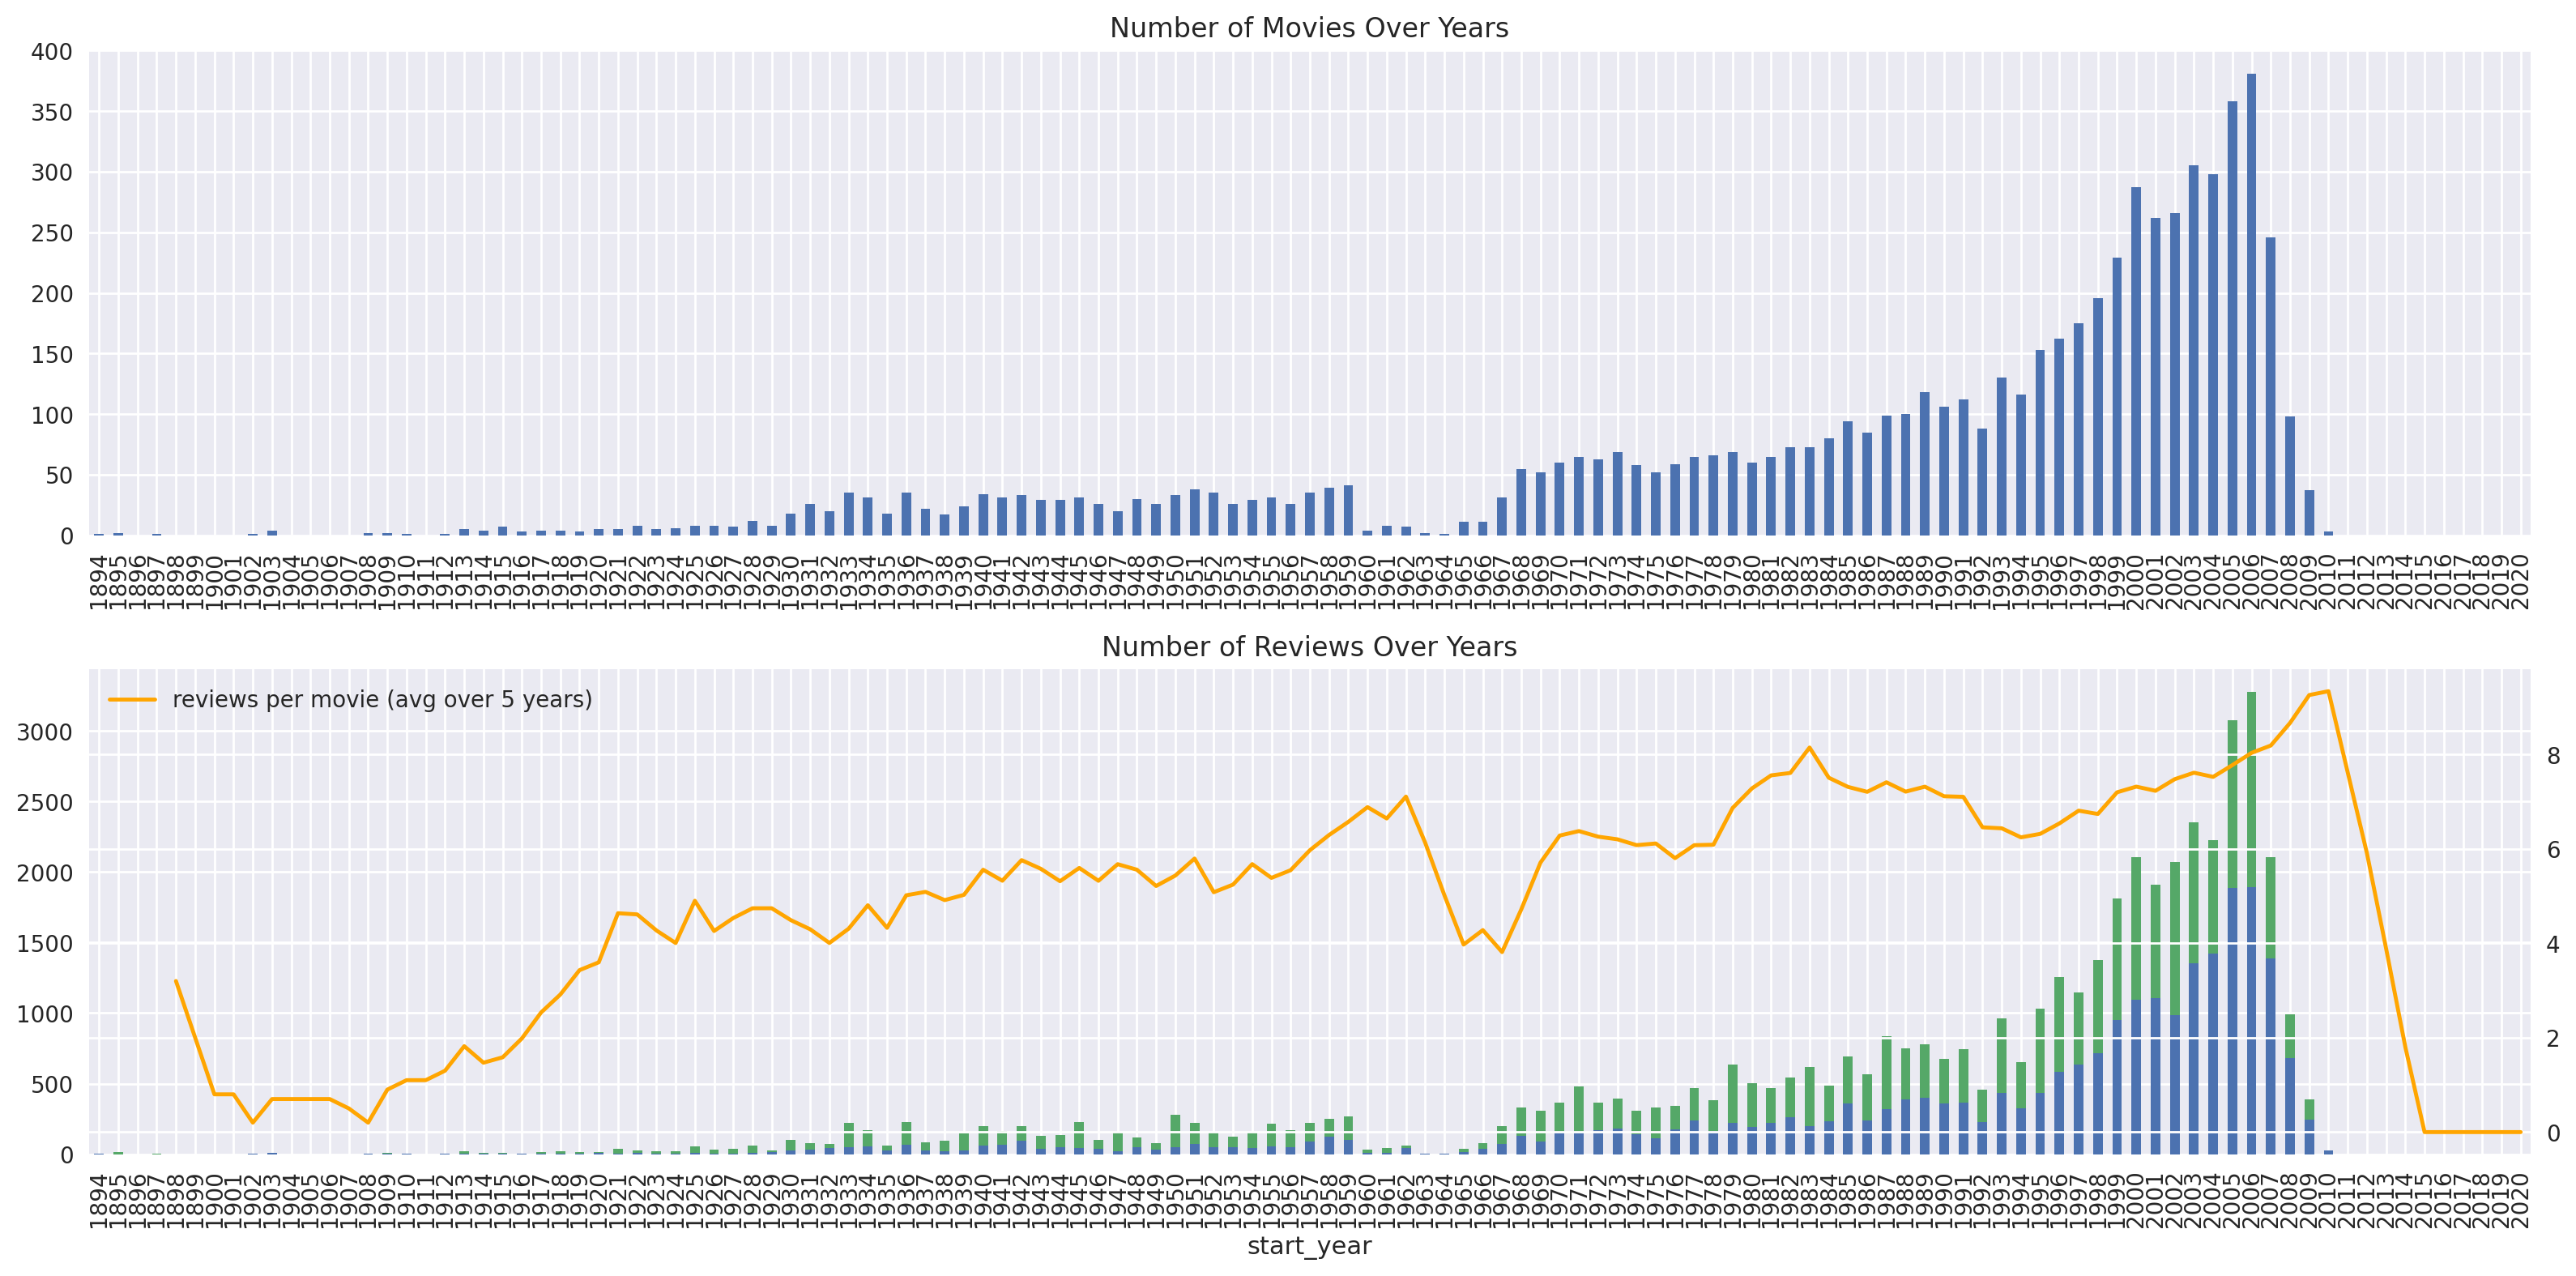

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Description: Most of the movie reviews from this dataset originate from 2006 with at least 3000 movies coming out that year. 

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

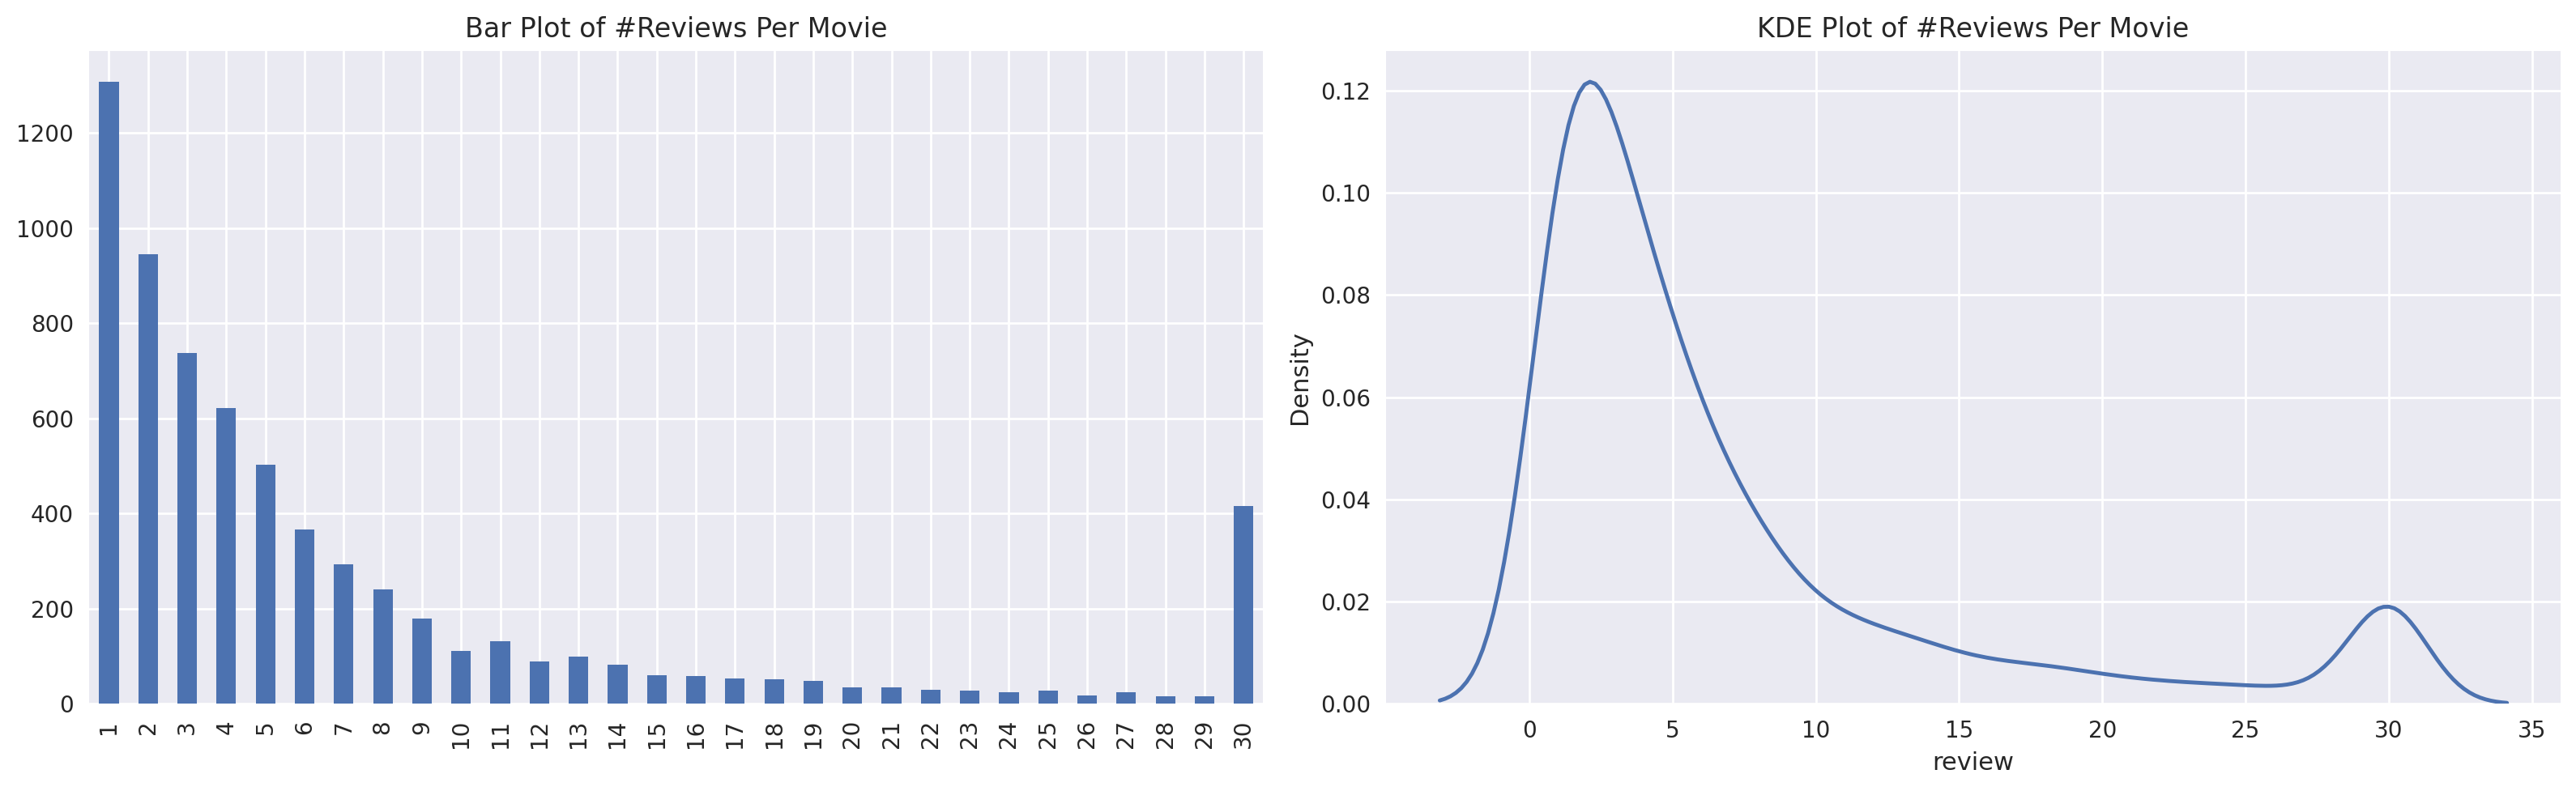

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

Description: In examining the data it seems most movies have at least one review. Approximately 400 of the movies had at least 30 reviews. 

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

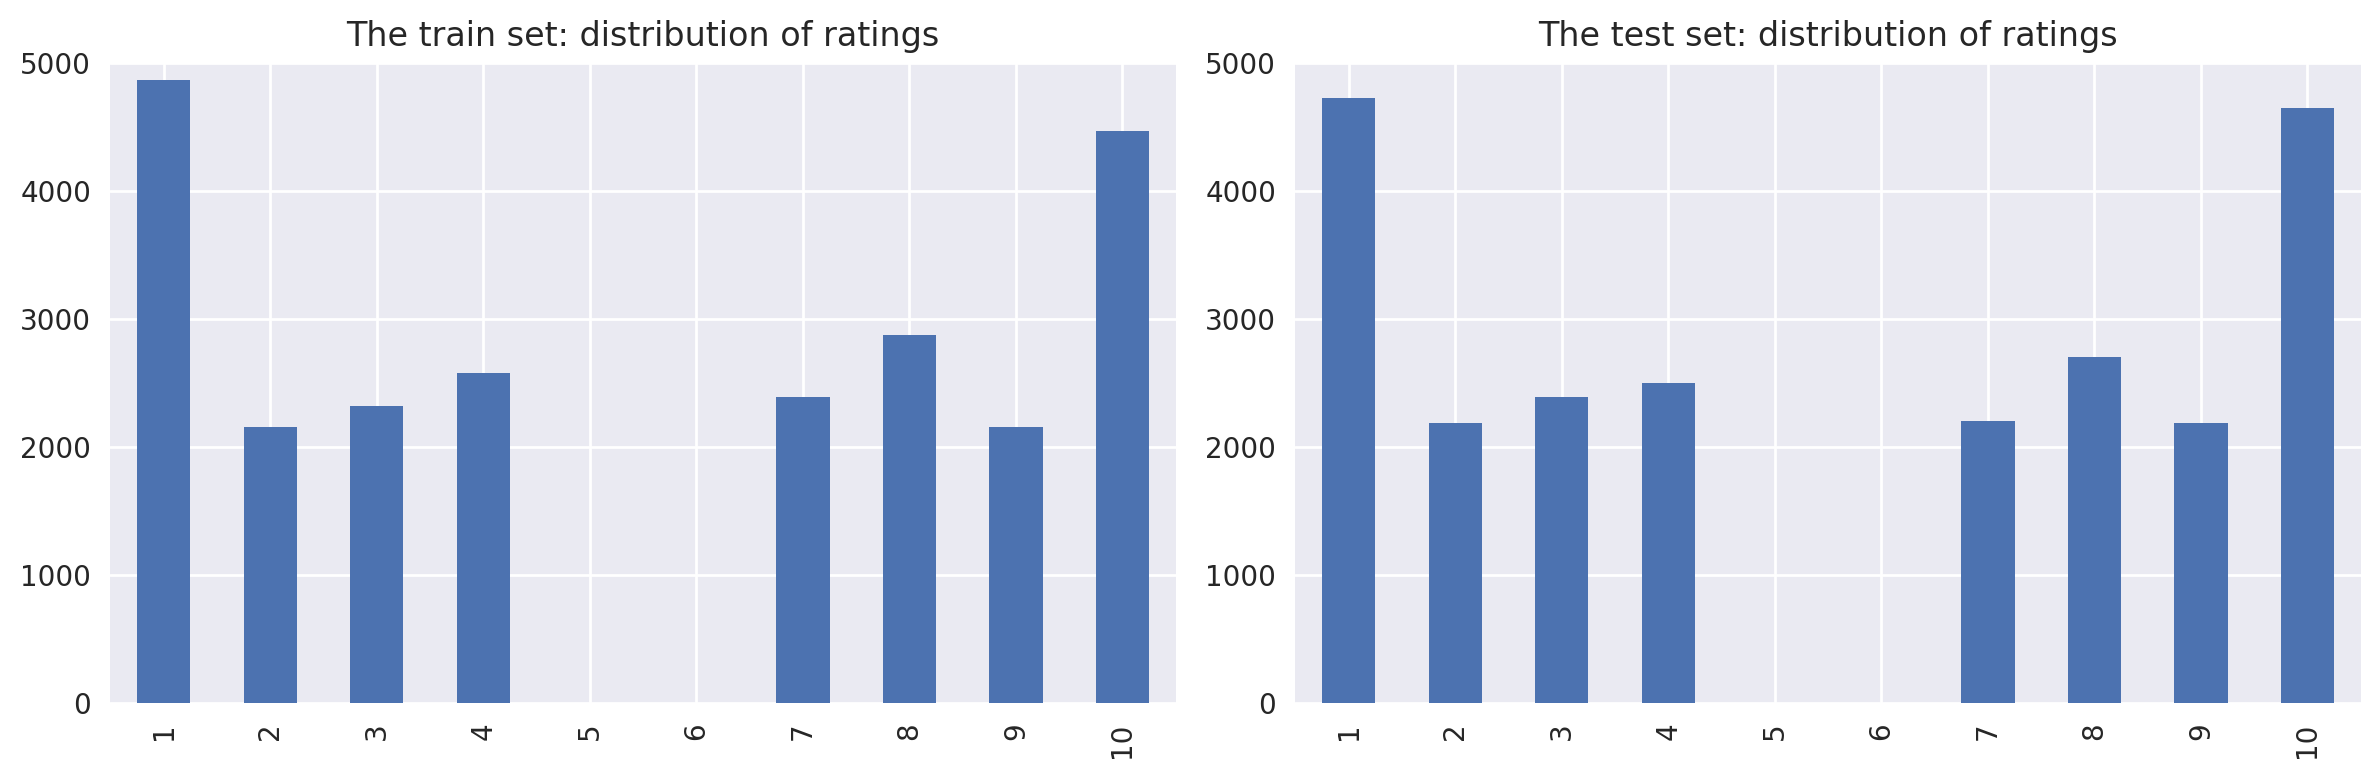

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Description: The distribution in ratings between the train and test sets are fairly close with a gap occuring for both for ratings at 5 and 6. 

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


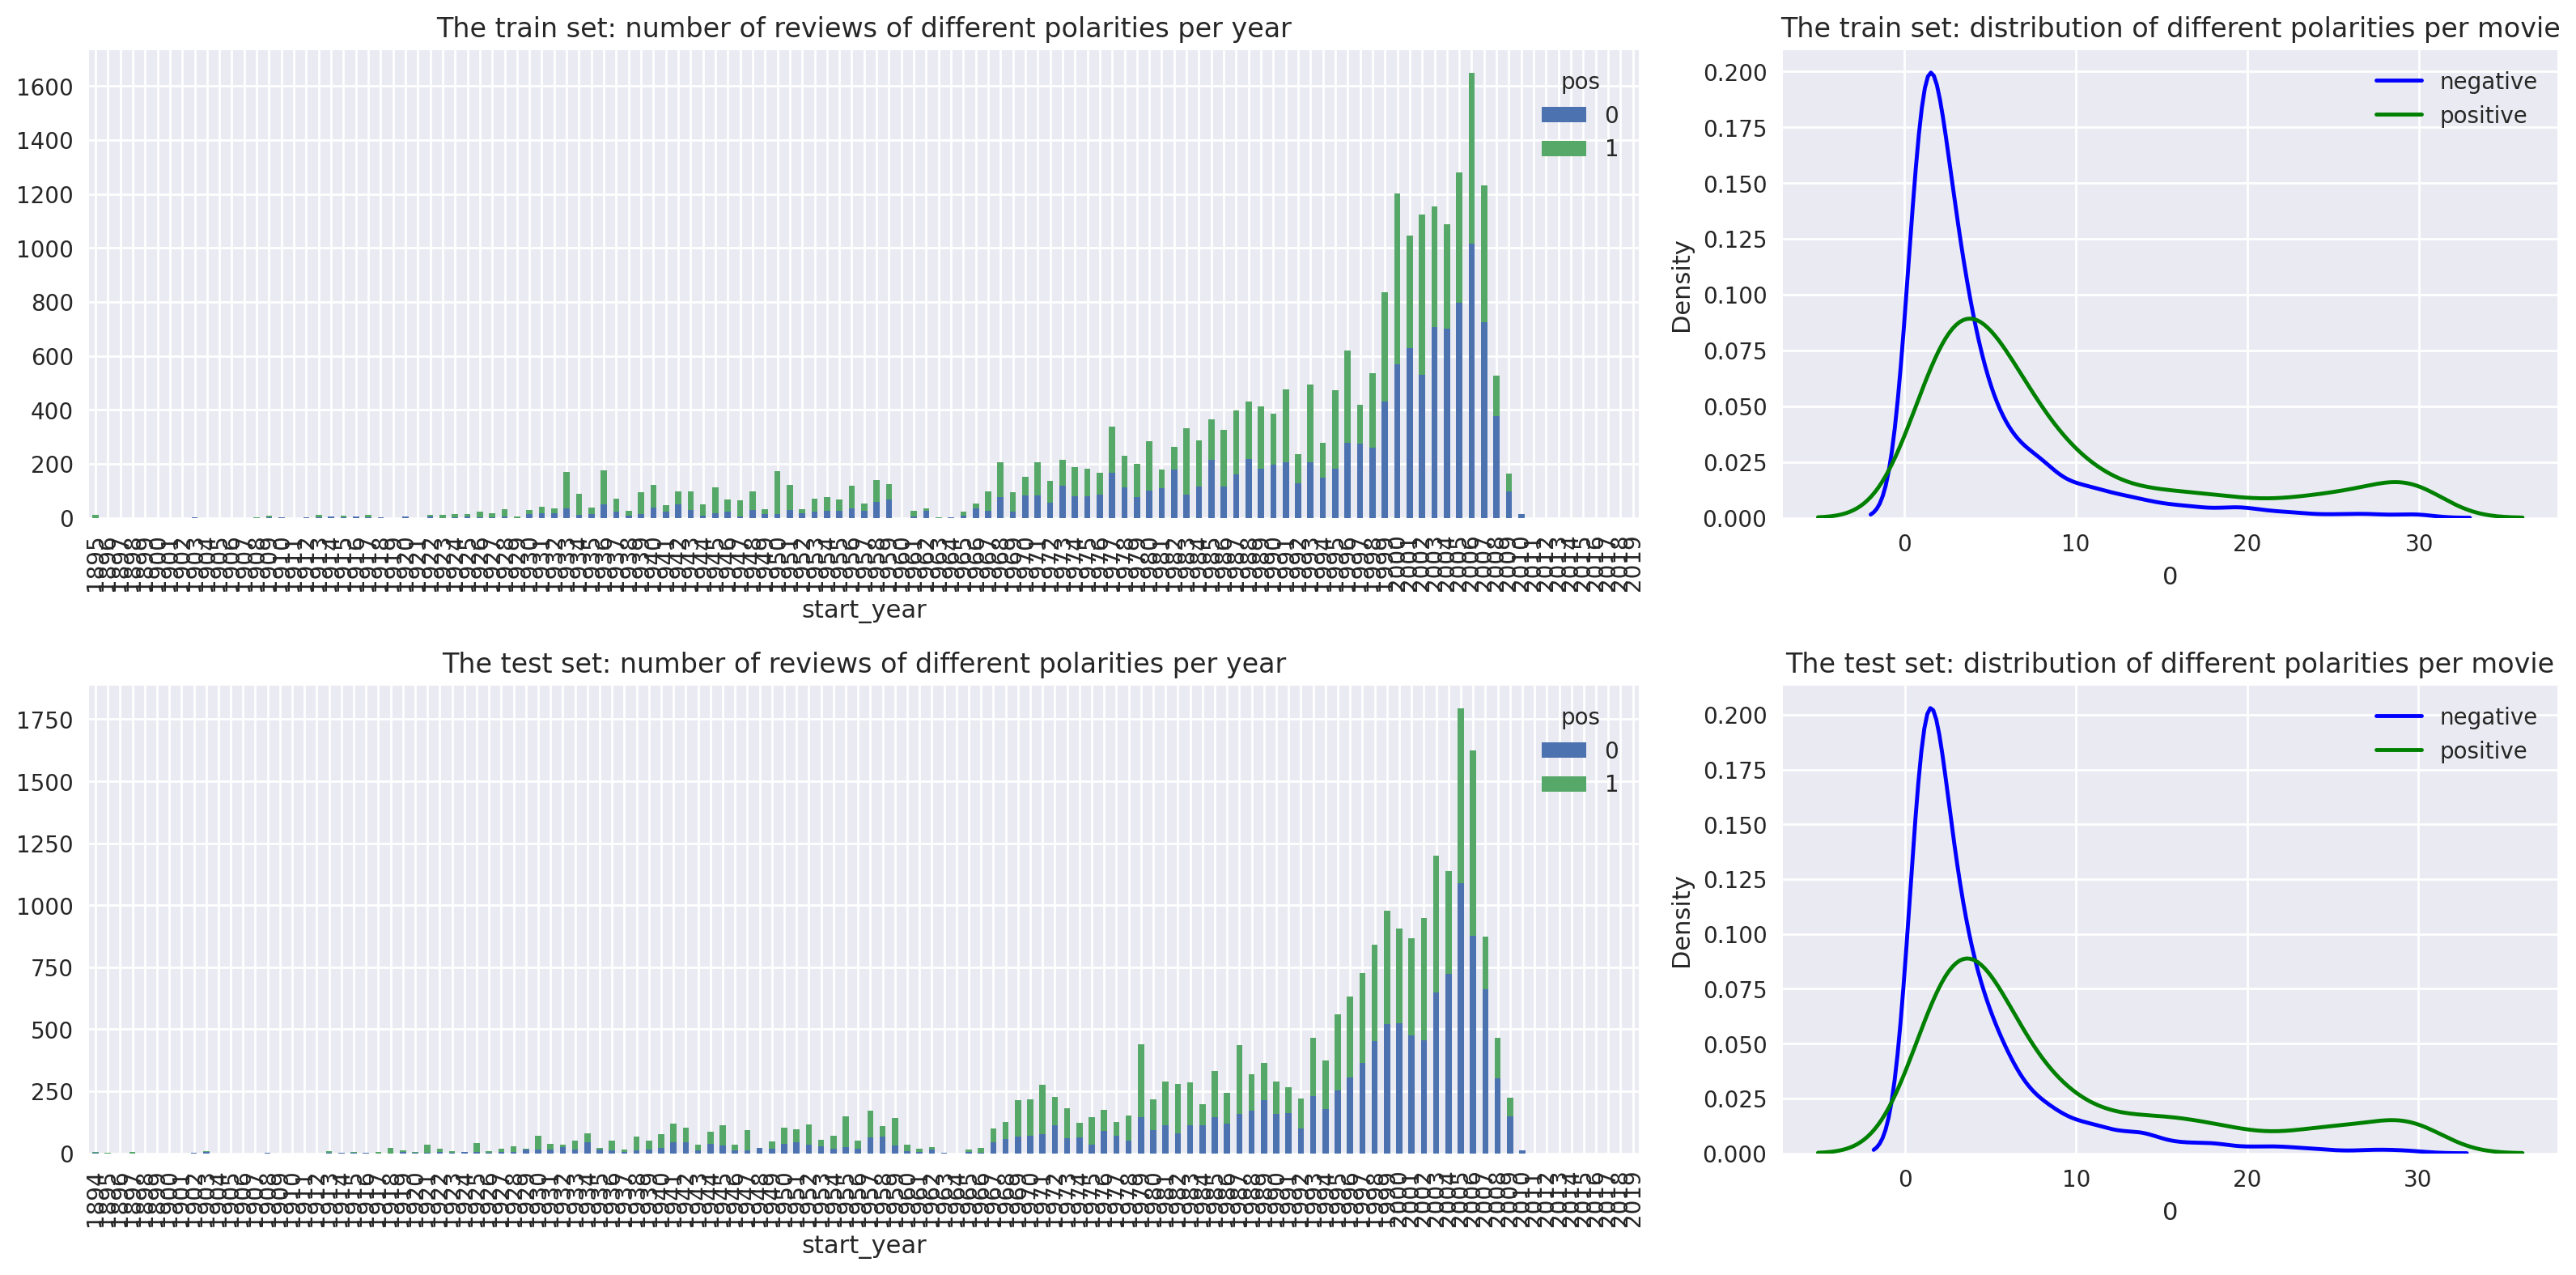

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Description of figures above: Again the train and test set are very similar. The distribution of the polarities in reviews is very close. 

Descritpion: The classes are balanced and the distribution of ratings in both the train and test sets are similar. Next step, will be to design an evaluation routine to be used for all the models generated. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [17]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [18]:
#Cleaning the reviews 
def clean_reviews(text): 

    text = re.sub(r'\d+','',text) #removing digits 
    text = re.sub(r'[^\w\s]','',text) #removing punctuation 
    text = text.lower() #convert to lowercase 

    return text 
    

In [19]:
#applying normalization to the 'review' column 
df_reviews['review_norm'] = df_reviews['review'].apply(clean_reviews)

display(df_reviews[['review','review_norm']].head())

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sin...
4,I'm totally agree with GarryJohal from Singapo...,im totally agree with garryjohal from singapor...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_y = df_reviews_train['pos']
test_y = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [21]:
#building models 

def build_model(model, train_X, train_y,test_X, test_y,
               hyperparameters = {},
               scoring=None, cv=5, model_str=None, cat_features=[],
               early_stopping_rounds=50, verbose=False):
    np.random.seed(42)
    best_score = 0 

    if model_str == 'dummy':
        model.fit(train_X,train_y)
        preds = model.predict(train_X)
        best_score = f1_score(train_y,preds)
        return model, best_score
        
    gs = GridSearchCV(model, param_grid=hyperparameters, cv=cv, scoring=scoring)
    gs.fit(train_X,train_y)
    if model_str == 'lgbm':
        gs.best_estimator_.fit(train_X,train_y, verbose=verbose)
        
    else: 
        gs.best_estimator_.fit(train_X,train_y)
    preds = gs.best_estimator_.predict(test_X)
    best_score = f1_score(test_y, preds)
    return gs.best_estimator_,best_score
            


In [22]:
dc = DummyClassifier()
best_dc_model, best_dc_f1 = build_model(dc,df_reviews_train['review_norm'],train_y,
                                                      df_reviews_test['review_norm'],test_y,
                                                      hyperparameters={'C':[.01,.1,1,10]},
                scoring='f1_weighted', cv=2,model_str='dummy')

In [23]:
#test set 
best_dc_f1 

0.0

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


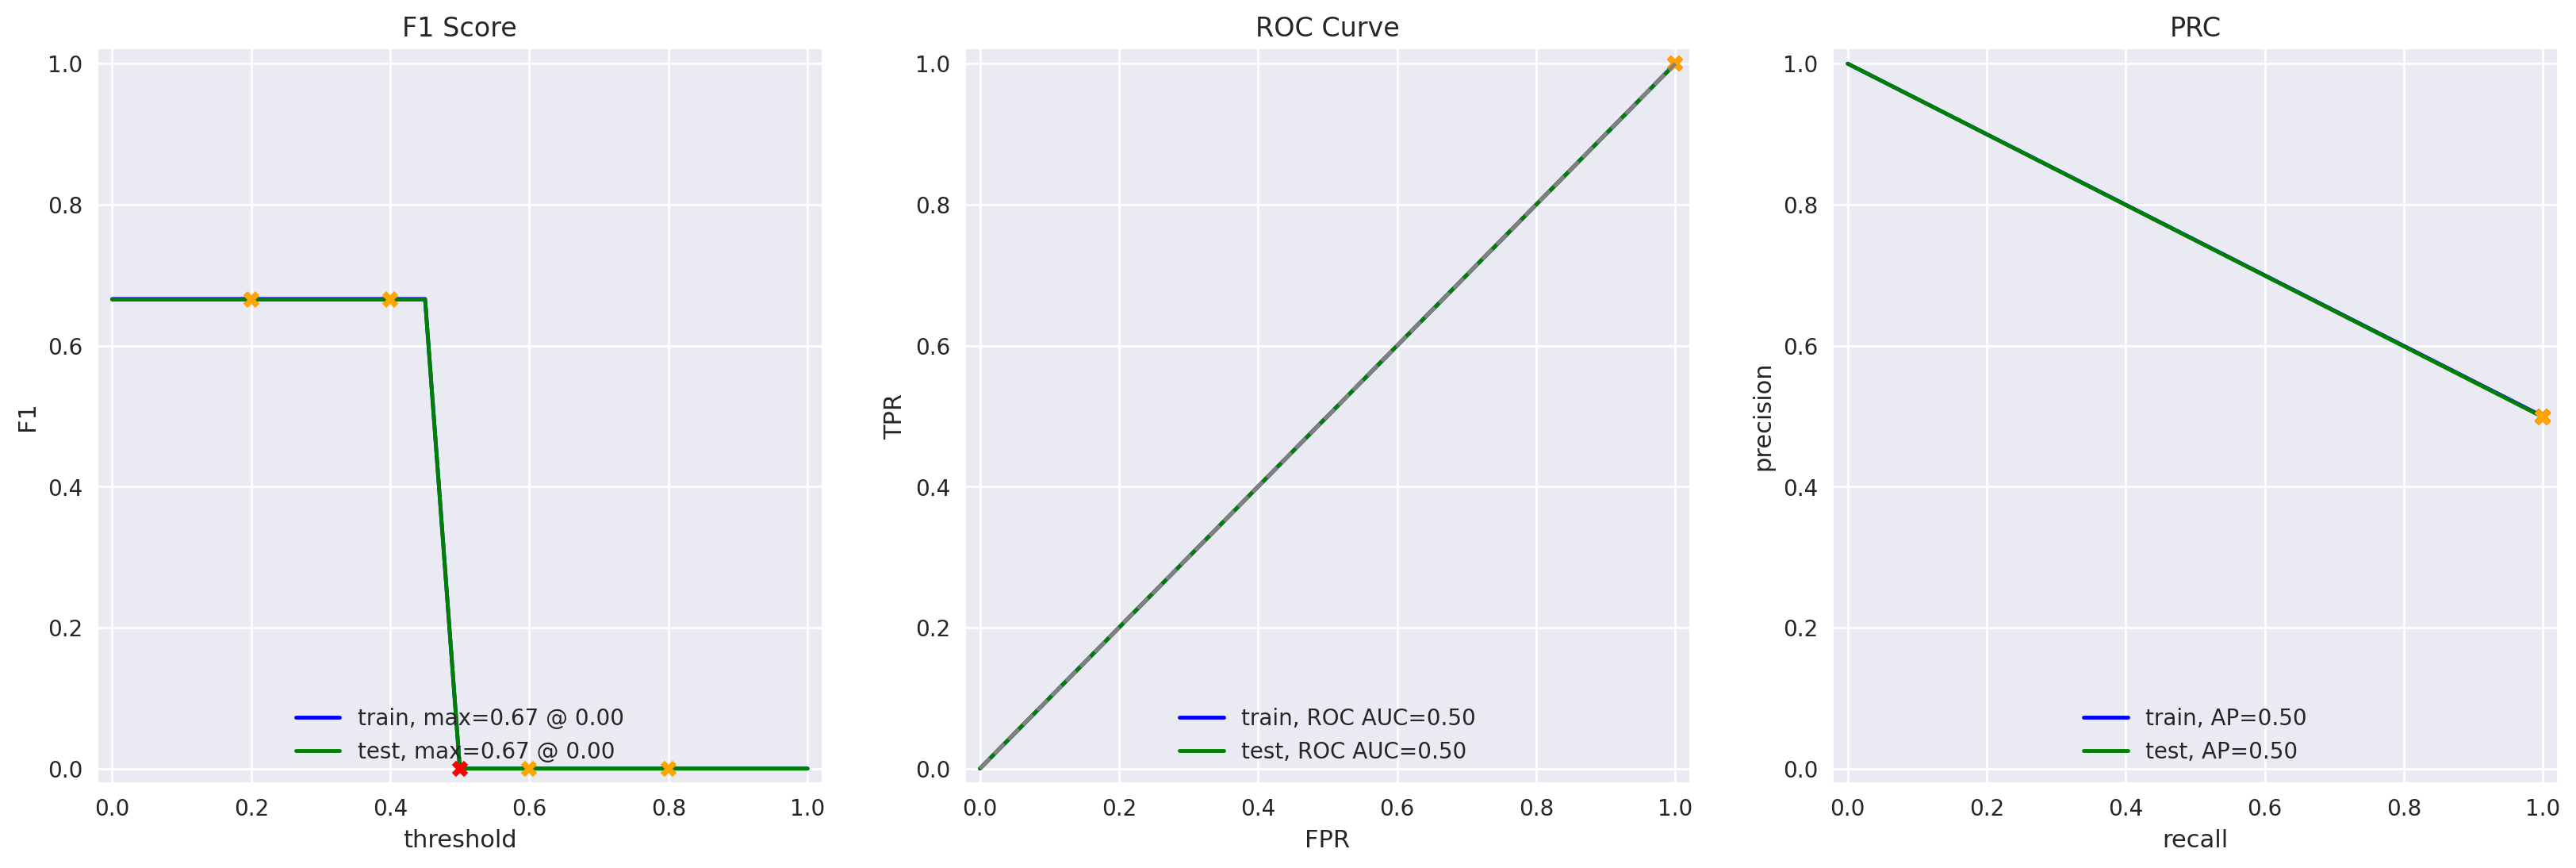

In [24]:
#Evaluating model 
evaluate_model(best_dc_model,df_reviews_train['review_norm'],train_y,df_reviews_test['review_norm'], test_y)

Description: The goal of the dummy classifier is to serve as a reference point. The baseline model illustrates the lowest possible performance illustrating that a more advanced model is requried to improve metrics and performance. 

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [25]:
lemmatizer = WordNetLemmatizer()

In [26]:
def text_preprocessing(text):
    tokens = word_tokenize(text)
    return " ".join(lemmatizer.lemmatize(token) for token in tokens)
    



In [27]:
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/student/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/student/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [30]:
df_reviews_train['reviews_nltk'] = df_reviews_train['review_norm'].apply(text_preprocessing)
df_reviews_test['reviews_nltk'] = df_reviews_test['review_norm'].apply(text_preprocessing)



In [31]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), max_df=0.9, min_df=10)
train_X =  tfidf_vectorizer_1.fit_transform(df_reviews_train['reviews_nltk'])
test_X = tfidf_vectorizer_1.transform(df_reviews_test['reviews_nltk'])

In [33]:
lr = LogisticRegression()
best_lr_model, best_lr_f1 = build_model(lr, train_X,train_y,
                                       test_X,test_y,
                                       hyperparameters={'C':[.01,.1,1,10]},
                scoring='f1_weighted', cv=5)

/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optim

In [34]:
best_lr_f1

0.879597664407791

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


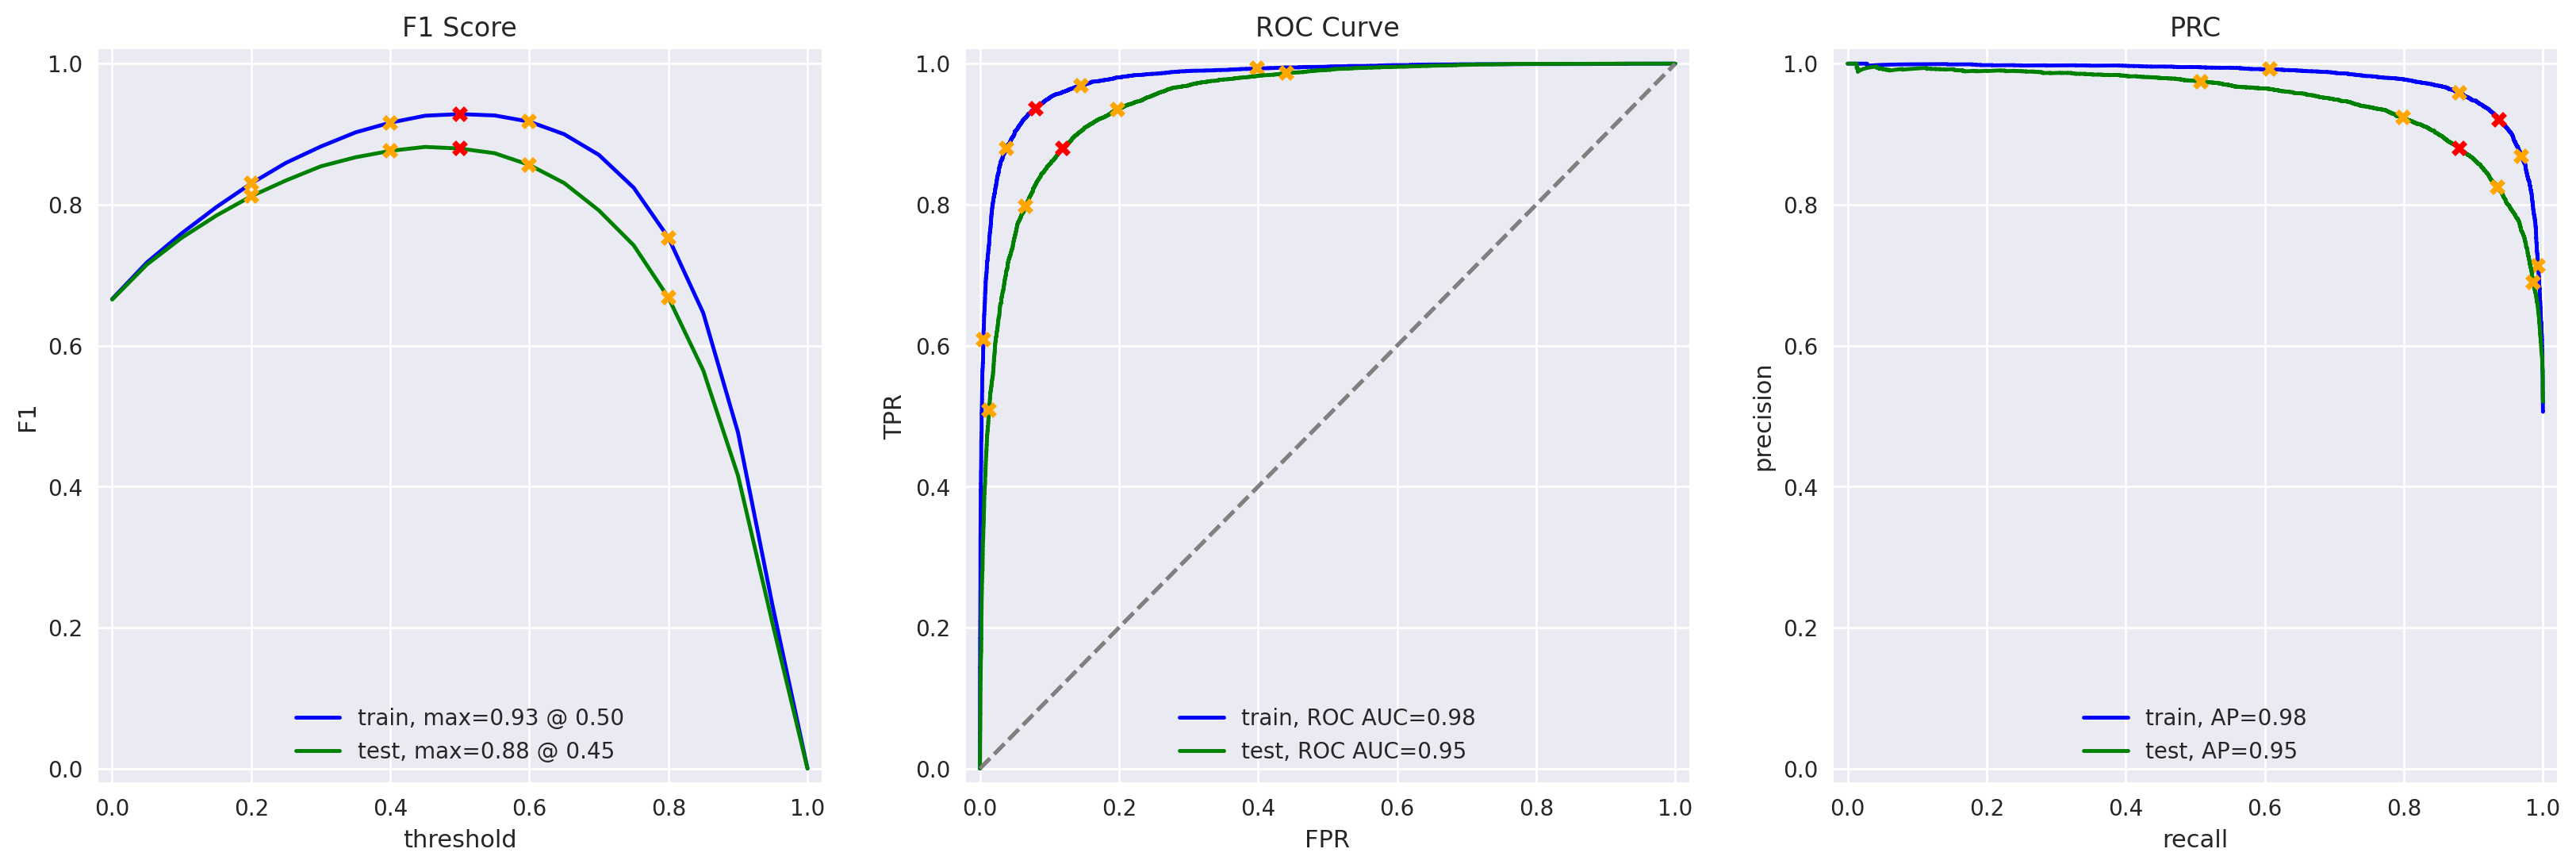

In [35]:
evaluate_model(best_lr_model,train_X,train_y,test_X,test_y)

### Model 3 - spaCy, TF-IDF and LR

In [36]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [37]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [38]:
tfidf_vectorizer_3 = TfidfVectorizer(stop_words=stopwords.words('english'),max_df=0.9,min_df=10)
df_reviews_train['reviews_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['reviews_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)




In [39]:
train_X =tfidf_vectorizer_3.fit_transform(df_reviews_train['reviews_spacy'])
test_X =tfidf_vectorizer_3.transform(df_reviews_test['reviews_spacy'])

In [40]:
best_lr_spacy_model, best_lr_spacy_f1 = build_model(lr, train_X, train_y,
                                                    test_X, test_y,
                                                    hyperparameters={'C': [.01, .1, 1, 10]},
                                                    scoring='f1_weighted', cv=5)

/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optim

In [41]:
best_lr_spacy_f1

0.8785778080210946

          train  test
Accuracy   0.92  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


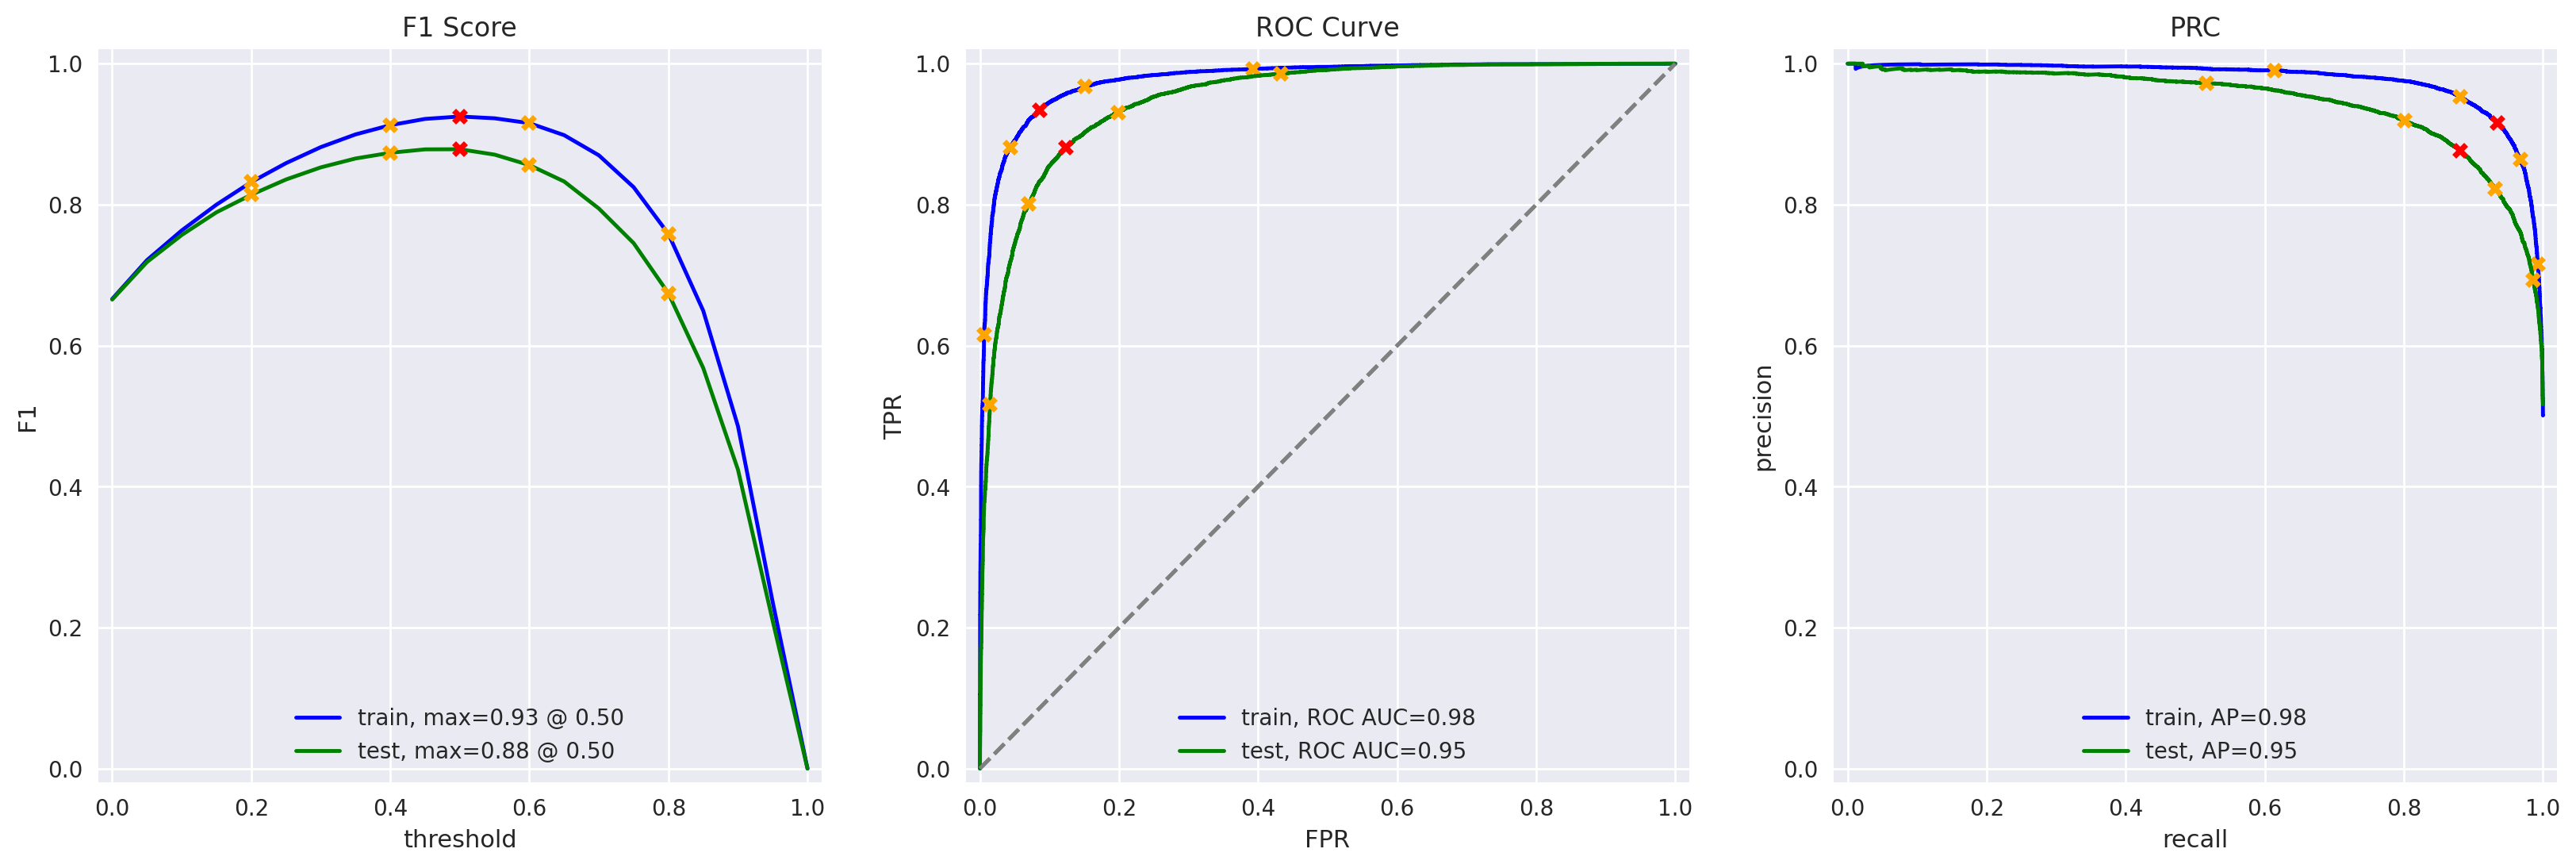

In [42]:
evaluate_model(best_lr_spacy_model, train_X,train_y,test_X,test_y)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [43]:
from lightgbm import LGBMClassifier

In [44]:
lgbm = LGBMClassifier(learning_rate=0.1, boosting_type ='gbdt',
                     objective = 'binary',
                     feature_fraction=0.8,
                     random_state=42)
best_lgbm_model, best_lgbm_f1 = build_model(lgbm,train_X,train_y,
                                           test_X,test_y,
                                           hyperparameters={'n_estimators':range(100,600,100)},
                scoring='f1_weighted',cv=3,model_str='lgbm',
            cat_features=[])

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [45]:
best_lgbm_f1

0.8687582478395981

          train  test
Accuracy    1.0  0.87
F1          1.0  0.87
APS         1.0  0.94
ROC AUC     1.0  0.94


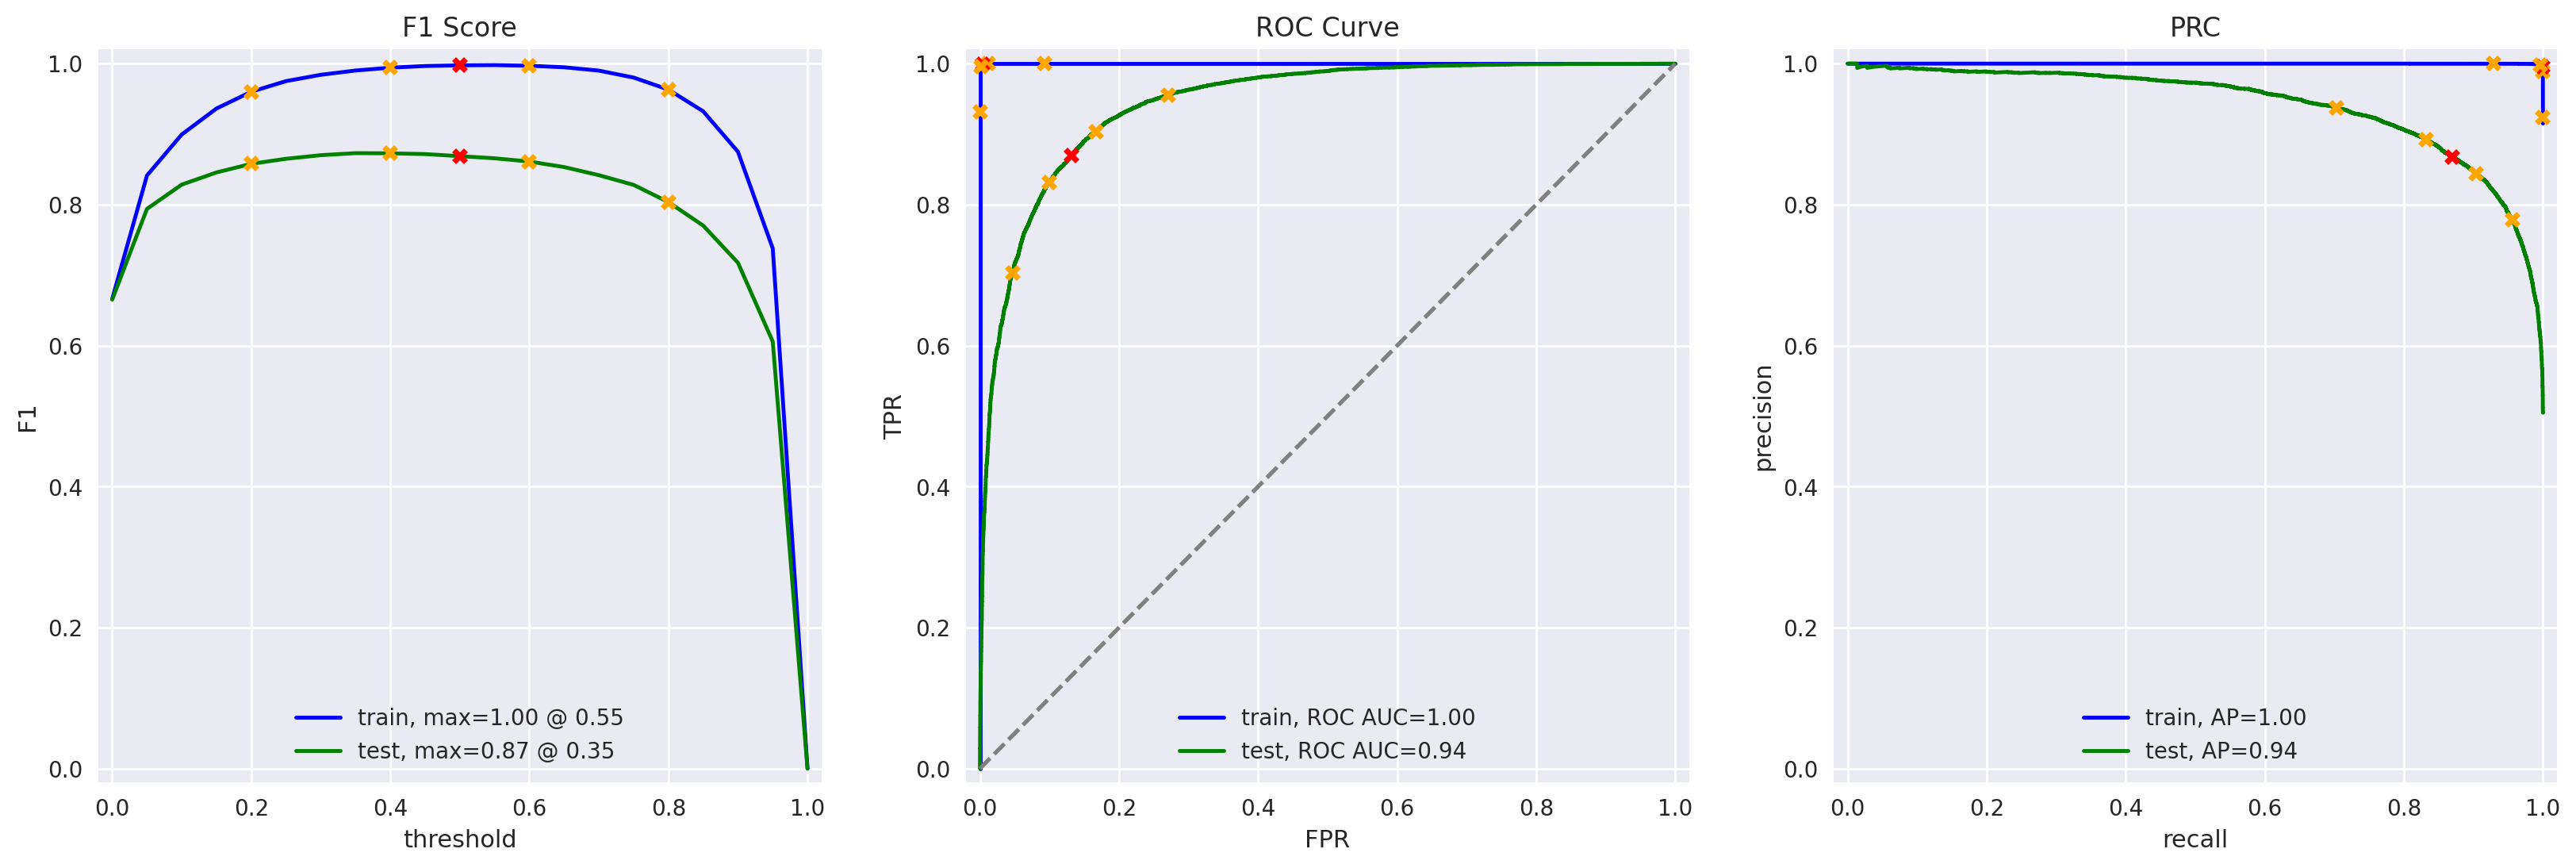

In [46]:
evaluate_model(best_lgbm_model,train_X,train_y,test_X,test_y)

In [47]:
model_results_df = pd.DataFrame({
    'model': ['LogisticRegression-NLTK', 'LogisticRegression-Spacy', 'LGBMClassifier'],
    'best_f1': [best_lr_f1, best_lr_spacy_f1, best_lgbm_f1]
})

In [48]:
model_results_df

,model,best_f1
0,LogisticRegression-NLTK,0.879598
1,LogisticRegression-Spacy,0.878578
2,LGBMClassifier,0.868758


Description: The Dummy Classifier performed as expected and serves as a reference point. In comparing the various LogisticRegression models the model that preprocessed using NLTK produced the best f1 score of 87.9%. This was only slightly higher than the model that used Spacy for preprocessing. The LightGBM produced a f1 score of 86.8% and took the longest time to complete training. Moreover, the models were trained using 5 fold cross-validation with hyperparameters tuning. Inspite, the time it took the LightGBM model produced the best result based on F1 score.  

###  Model 9 - BERT

Description: Skip due to slow processing.

In [49]:
#import torch
#import transformers

In [50]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [51]:
#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
#    ids_list = []
#    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    # ids_series = texts.apply(lambda x: tokenizer.encode(x.lower(),
    #                                                       add_special_tokens = True, 
#                                                           truncation=True, 
#                                                           max_length=max_length)
#                             )
    # <put your code here to create ids_list and attention_mask_list>
#     ids_series = ids_series.apply(lambda x:np.array(x +[0]*(max_length-len(x))))
#     attention_mask_series = ids_series.apply(lambda x: np.where(x !=0, 1,0))
#    for input_text in texts:
#        ids =tokenizer.encode(input_text.lower(), add_special_tokens = True, truncation=True, max_length=max_length)
#        padded = np.array(ids + [0]*(max_length - len(ids)))
#        attention_mask = np.where(padded !=0,1,0)
#        ids_list.append(padded)
#        attention_mask_list.append(attention_mask)
#    if force_device is not None:
#        device = torch.device(force_device)
#    else:
#       device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#    model.to(device)
#    if not disable_progress_bar:
#        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

#    embeddings = []

#    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
#        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
#        with torch.no_grad():            
#            model.eval()
#            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
#        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    
#return np.concatenate(embeddings)

In [52]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
#rain_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [53]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [54]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [55]:
# with np.load('features_9.npz') as data:
#    train_features_9 = data['train_features']
#    train_features_9 = data['test_features']

In [56]:
#print(df_reviews_train['review)_norm'].shape)
#print(train_features_9.shape)
#print(train_y.shape)

In [57]:
#lr = LogisticRegression()
# best_bert_model, best_bert_fq = build_model(lr,train_features_9, train_y,
#                                          test_features_9, test_y,
#                                          hyperparamters={'C': [.01,.1,1,10]},
#                  scoring= 'f1_weighted', cv=5)

In [58]:
#test
#best_bert_f1
#evaluate_model(best_bert_model,train_features_9, train_y, test_features_9,test_y)

## My Reviews

In [59]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_reviews)


my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didnt expect the reboot to be so good writer...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Model 2

In [60]:
texts = my_reviews['review_norm']

model_2 = best_lr_model

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.19:  i did not simply like it not my kind of movie
0.19:  well i was bored and felt asleep in the middle of the movie
0.61:  i was really fascinated with the movie
0.17:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didnt expect the reboot to be so good writers really cared about the source material
0.55:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.05:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 3

In [61]:
texts = my_reviews['review_norm']
model_3 = best_lr_spacy_model

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.22:  i did not simply like it not my kind of movie
0.12:  well i was bored and felt asleep in the middle of the movie
0.51:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.20:  i didnt expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 4

In [62]:
texts = my_reviews['review_norm']

model_4 = best_lgbm_model

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.62:  i was really fascinated with the movie
0.19:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didnt expect the reboot to be so good writers really cared about the source material
0.81:  the movie had its upsides and downsides but i feel like overall its a decent flick i could see mysel
0.08:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Model 9

In [63]:
#texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
#    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

## Conclusions

The objective of this project was to test several different models and determine the best performance based on F1 score. After training and testing several models the best F1 score was achieved by the LightGBM Classifier. This model produced the best f1 score of 86.8%. However, it is only slightly better than the LogisticRegression models. Both LogisticRegression models took approximately the same amount of time to train and produced very similar results. This would suggest that the LightGBM Classifer would provide the strongest ability to detect negative movie reviews for Film Junky Union. 